In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
data = pd.read_csv('all_items_improved.csv', sep=',')

#### Potential bugs found :
- numbers in the menu item text (meat weight for instance, nb of snails 6/12 + price in the text)
- prices negative (special offers for lunch menus, ..)
- zip codes missing
- comma forgotten in the price (2700 instead of 27,00)

#### Observations : 
- tags only in the first row of each restaurants
- rest_avg_price does not represent the average price of a restaurant item but rather the average price of eating at the restaurant under the opinion of the owner.

## Improving/Debugging the data

### Supressing negative price (special offers on the menu, ex : -1e for lunch)

In [4]:
data = data[data.item_price > 0]

### 'location' feature, switching to zip codes

In [5]:
data['rest_location'] = data['rest_location'].apply(lambda x: x.split("\n")[1].strip())
data['rest_location'] = data['rest_location'].replace('', '0').replace('Bercy Village', '0').astype(int)

In [6]:
data['rest_location'].unique()

array([    0, 75002, 75018, 75015, 75006, 75010, 75017, 75014, 75008,
       75012, 75003, 75011, 75005, 75001, 75007, 75020, 75019, 75004,
       75116, 75013, 75009, 75016])

### Dropping item_prices with prices over 200e 
##### (noise + errors in the comma location most of the times), will only affect a little our predictions for wine and champagne

In [7]:
data = data[data.item_price < 200]

## Descriptive Statistics

### Dataset Size

In [7]:
print('Number of restaurants: ', data.rest_name.nunique())
print('Number of menu items: ', data.shape[0])

Number of restaurants:  4599
Number of menu items:  80379


### Menu items prices Distribution

In [8]:
data.item_price.describe()[1:].round(1)

mean     13.9
std      13.9
min       0.6
25%       6.0
50%      10.0
75%      16.5
max     199.0
Name: item_price, dtype: float64

Proportion of items < 10€: 49.43%
Proportion of items > 100€: 0.21%


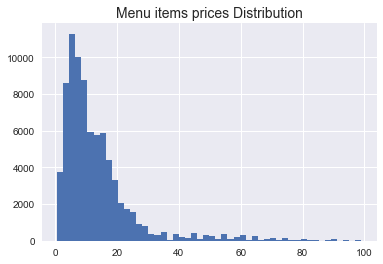

In [9]:
nb_items = float(len(data.item_price))
print('Proportion of items < 10€: {0:.2f}%'.format(100*(data.item_price < 10).sum()/nb_items))
print('Proportion of items > 100€: {0:.2f}%'.format(100*(data.item_price > 100).sum()/nb_items))

a=plt.hist(data[data.item_price < 100].item_price, bins=50)
plt.title('Menu items prices Distribution', fontsize = 14);

### The Fork average prices / ratings

In [10]:
data.drop_duplicates(['rest_name'])[['rest_avg_price', 'rest_global_rating']].describe().round(1)[1:]

,rest_avg_price,rest_global_rating
mean,29.6,8.4
std,18.3,1.0
min,9.0,2.0
25%,20.0,8.1
50%,25.0,8.6
75%,34.0,9.0
max,330.0,10.0


### Price disparities between locations

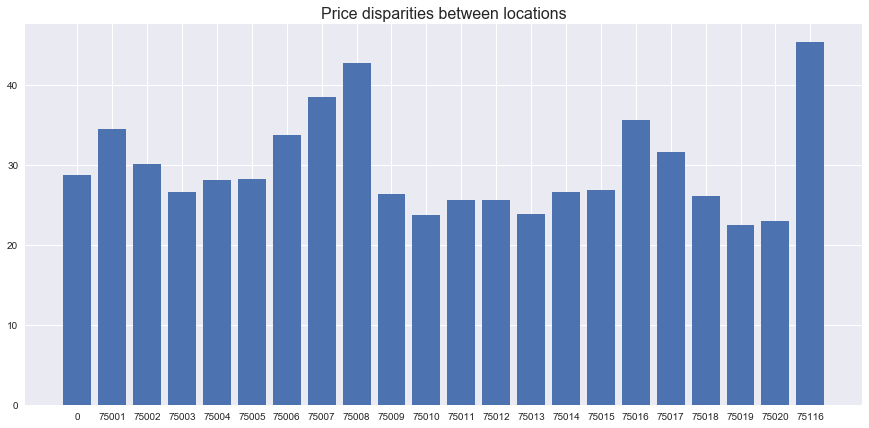

In [11]:
df = data.groupby(data.rest_name).first()
price_location = df.groupby(df.rest_location).rest_avg_price.mean()

x_axis = range(len(price_location))
big_fig = plt.figure(1, figsize=(15,7))
fig = plt.subplot(111)
fig.bar(x_axis, price_location.values)
fig.set_xticks(x_axis)
fig.set_xticklabels(price_location.index)
fig.set_title('Price disparities between locations', fontsize=16)
plt.show();

### Price standard deviation per restaurant

In [12]:
print('Std of the prices inside a restaurant: ', data.groupby(data.rest_name).item_price.std().mean().round(1), '€')

Std of the prices inside a restaurant:  11.3 €


### Statistics on the nb of words in the items' texts

In [13]:
data['item_length'] = data['item'].apply(lambda x: len(x.split()))
data['item_length'].describe()[1:]

mean     5.241991
std      4.034759
min      1.000000
25%      3.000000
50%      4.000000
75%      7.000000
max     46.000000
Name: item_length, dtype: float64

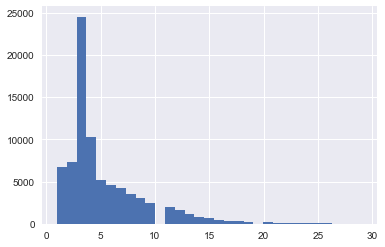

In [14]:
data[data.item_length<30].item_length.hist(bins = 31);

### Handling tags 

In [15]:
data.head()

,rest_name,item,item_price,rest_url,rest_global_rating,rest_avg_price,rest_location,rest_tags,item_length
0,Les Garcons Bouchers,Bruschetta Foie de Volaille sur nid de Roquett...,10.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,"['Français', 'Bistrot', 'Entre amis', 'Anniver...",12
1,Les Garcons Bouchers,Planche de charcuteries (à partager à 2 ou 3 p...,25.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],10
2,Les Garcons Bouchers,Poêlé de Foie de Volaille sur Nid de Roquette,14.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],9
3,Les Garcons Bouchers,Le Hamburger Rossini 200 gr,26.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],5
4,Les Garcons Bouchers,La côte de Bœuf ~ 500 gr,33.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,0,[],7


In [8]:
from ast import literal_eval
data.rest_tags = data.rest_tags.apply(literal_eval)


In [17]:
tags =  data.drop_duplicates(['rest_name']).rest_tags

all_tags =  set.union(*map(set, tags))
print("Number of different tags: ", len(all_tags))
print("Tag properties: \n")
tags.apply(lambda l: len(set(l))).describe()[1:]

Number of different tags:  243
Tag properties: 



mean    11.273755
std      3.051121
min      5.000000
25%      9.000000
50%     11.000000
75%     13.000000
max     38.000000
Name: rest_tags, dtype: float64

In [18]:
from collections import Counter
most_frequent = Counter()

for item in tags:
    most_frequent.update(set(item))
    
most_frequent.most_common(25)

[('...', 4599),
 ('Île-de-France', 4597),
 ('Français', 4140),
 ('Traditionnel', 2240),
 ('Italien', 1976),
 ("Certificat d'Excellence TripAdvisor 2017", 1318),
 ('Paris - Centre', 1192),
 ('Les mieux notés', 856),
 ('Bistrot', 843),
 ('Plats végétariens', 840),
 ('Branché', 749),
 ('Japonais', 644),
 ('Indien', 640),
 ('World food', 624),
 ('Opéra - Grands Boulevards', 595),
 ('Asiatique', 500),
 ('Américain', 481),
 ('Thailandais', 466),
 ('Chinois', 457),
 ('Brasserie', 393),
 ('Libanais', 393),
 ('Bastille', 390),
 ('Anniversaire', 371),
 ('Paris 9ème', 368),
 ('Crêperie', 360)]

In [19]:
# Remove "..."
most_frequent_tags = [i[0] for i in most_frequent.most_common(25)[1:]]
# Build the lists


In [20]:
lengths = data.rest_name.value_counts().to_dict()
has_tags = {tag: [] for tag in most_frequent_tags}
for  _, (rest, tags_list) in data.drop_duplicates(['rest_name'])[['rest_name', 'rest_tags']].iterrows():
    length = lengths[rest]
    for tag in most_frequent_tags:
        if tag in tags_list:
            has_tags[tag].extend([1]*length)
        else:
            has_tags[tag].extend([0]*length)

In [21]:
for tag, values in has_tags.items():
    data[tag] = values

In [22]:
# Black magic ahead
n_tags_col = []
for rest, n_tags in zip(data.rest_name.drop_duplicates(), tags.apply(lambda l: len(set(l)))):
    n_tags_col.extend([n_tags] * lengths[rest])
data["n_tags"] = n_tags_col

### Machine learning wizardry

#### We are now writing in data_ml because we're doing transformations which suck for visualization
#### Anything that helps visualization should go above and also change data

In [26]:
from sklearn.preprocessing import LabelEncoder


data_ml = data.drop(["rest_url", "rest_tags"], axis=1).copy()
rest_name = LabelEncoder()
rest_name.fit(data_ml.rest_name)
data_ml.rest_name = rest_name.transform(data_ml.rest_name)

In [27]:
def restaurantKfold(n_splits=5, shuffle=True):
    length = data_ml.rest_name.nunique()
    restaurants = data_ml.rest_name.unique()
    if shuffle:
        np.random.shuffle(restaurants)
    for i in range(n_splits):
        test = restaurants[int(length*i/n_splits):int(length*(i+1)/n_splits)]
        mask = data_ml.rest_name.isin(test)
        yield ~mask, mask

In [40]:
# Ideally we would use MAE instead of MSE for RFR but this crashes here
# https://github.com/scikit-learn/scikit-learn/issues/7811

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


clf = RandomForestRegressor(n_estimators=35, criterion="mse")
clf = GradientBoostingRegressor()
scores = []

for i, (tr_ix, te_ix) in enumerate(restaurantKfold()):
    print("Handling fold: ", i+1)
    train_X, train_y = data_ml.drop(['item', 'item_price', 'rest_name'], axis=1).loc[tr_ix], data_ml.item_price.loc[tr_ix]
    test_X, test_y = data_ml.drop(['item', 'item_price', 'rest_name'], axis=1).loc[te_ix], data_ml.item_price.loc[te_ix]
    clf.fit(train_X, train_y)
    preds = clf.predict(test_X)
    scores.append(mean_absolute_error(test_y, preds))

Handling fold:  1
Handling fold:  2
Handling fold:  3
Handling fold:  4
Handling fold:  5


In [41]:
scores = np.array(scores)
print("Mean: ", scores.mean().round(2))
print("Std.: ", scores.std().round(2))

Mean:  7.6
Std.:  0.18


In [37]:
for feat, imp in zip(data_ml.drop(['item', 'item_price', 'rest_name'], axis=1).columns, clf.feature_importances_*100):
    print(feat, "{0:.2f}%".format(imp))

rest_global_rating 9.03%
rest_avg_price 28.79%
rest_location 7.82%
item_length 19.66%
Île-de-France 0.01%
Français 0.89%
Traditionnel 1.63%
Italien 1.68%
Certificat d'Excellence TripAdvisor 2017 1.56%
Paris - Centre 1.67%
Les mieux notés 1.28%
Bistrot 1.62%
Plats végétariens 1.24%
Branché 1.24%
Japonais 1.04%
Indien 1.10%
World food 1.17%
Opéra - Grands Boulevards 0.96%
Asiatique 1.03%
Américain 1.05%
Thailandais 1.56%
Chinois 0.84%
Brasserie 1.18%
Libanais 1.02%
Bastille 0.97%
Anniversaire 0.82%
Paris 9ème 0.72%
Crêperie 0.89%
n_tags 7.53%
